### High Level Outcomes (also shown below, placed here for convenience)
* Compared to the performance of the loans in the testing dataset, this model would increase annualized returns by 38.5% (% change from 1.92% to 2.65%). 
* If we were to extrapolate to the results on the test dataset to the overall loan portfolio, we could estimate the following:
    * 11.2% default rate
    * 275M in returns vs. 3.4B in capital 
    * The model would deliver roughly 80M fewer in returns, but require nearly 2.5B less capital to do so 
* This model would outperform the proposed intervention of setting an interest cap of 13.5%, because it would deliver about 7M more in revenue, while also using about 17M less capital. 
* The company would generate smaller returns in absolute terms if they used this model, 22% less in absolute terms, but their % returns would increase because they would generate those returns via deploying 45% less capital. Another way to look at is that the capital cost to generate returns from their loan portfolio would be nearly cut in half. 
* This model has the highest annualized returns compared to the two interventions proposed in the EDA Notebook:
    * No loans below Grade D, 2.2% annualized return
    * Setting a interest rate cap of 13.5%, 2.4% annualized return
* The value this model would have for the company would depend on a lot of factors: namely, are they going to optimize for capital efficiency or gross returns? Also, the company could elect to make up the difference with growth and marketing. I.e. aggressively seek out additional customers who meet their new lending standards.
* The model and the suggested interventions from the data analysis are saying the same thing, after a certain point capital efficiency drops off substantially and the company is investing a large sum of money for very little gain

##### Key Notes:
* The key evaluation statistic will be the financial performance of the loans chosen by the model, rather than F1 or AUC. That being said, F1 was the metric used for cross fold validation and for determining the most valuable features. 
* XG Boost was the "winning model", I've included an L1 Logistical Model from Sklearn just as a reference. The performance of both models was actually quite close, but XG Boost ran in 7 seconds on a GPU vs. 11 mintues for SK Learn on CPU, as the latter lacks GPU acceleration capability and XG Boost is just faster in general. An L2 regressor and a decision tree were also tried, but not included in this notebook due to the L1 giving better results. 
* Used undersampling techniques to deal with the data imbalance (more paid off loans than defaults) rather than using techniques that would "simulate" extra data 
* The hyperparameters were largely chosen by grid searches done separately from this analysis 
* Predictions made based on the "paid" column, namely, if the customer paid off their loan the column has a one, if they defaulted, it has zero. 
* Given this is an imbalanced dataset, the key metric targeted as the F1 score as it's a balance between the true positive rate and what % of loans that were positive did the model classifiy as good. E.g. If the model is right 85% of the time when it comes to classifying good loans, but only recognizes 70% of the loans as good, the true value of the model is somewhere between those two numbers. 


#### Key statistics on the loans in the original dataset
* Default Rate: 19.18% 
* Gains from good loans: ~912m
* Losses from bad loans: ~560m
* Net Gains: ~353m 
* The  loans in the bottom two "grades" are unprofitable overall, with the grade above it barely profitable (i.e. grades E, F, G) 

#### Financial Targets for the machine learning model 
* The model is attempting to beat one or both of the potential interventions revealed in the EDA portion of this analysis, namely:
    * Not originating loans to customers with loan grades below D, meaning: <16.5% default rate, >351M in gains, <5.09B in deployed capital 
    * Setting an interest cap at 13.5%, <3.6B in deployed capital, >270M in gains, <10.6% default rate

The general idea is that the model doesn't per se have value from being just accurate, instead the loan portfolio identified by the model has to outperform the typical "human identified" interventions to improve portfolio performance. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from eda_class import EDA
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from sklearn import linear_model, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
from xgboost import plot_importance
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from numpy import sort
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import loadtxt
from xgboost import plot_importance 
from matplotlib import pyplot
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# set size parameters for the plots 

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

# set view parameters for the pandas data frames 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999


In [3]:
# instantiate the EDA functions that will help us analyze the data 

eda_functions = EDA()


In [4]:
%%time

# read in data 

data = pd.read_csv('data/updated_lc_ML_ready_data_april2022.csv')

data.head()

CPU times: user 1.56 s, sys: 140 ms, total: 1.7 s
Wall time: 1.7 s


,funded_amnt,int_rate,installment,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,tot_cur_bal,total_bal_ex_mort,emp_length_months,dti_dec,length_of_credit_history,total_payments,post_loan_dti,net_gain,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,paid,application_type_Individual,application_type_Joint App
0,20000.0,0.1485,691.84,0.0,690.0,0.0,0.0,8.0,0.0,0.0,0.845,12.0,0.0,0.0,0.0,3.0,5356.0,0.0,102.0,16.0,10.0,0.0,9.0,0.0,0.0,1.0,0.0,100.0,0.0,37491.0,37491.0,72,0.1245,102,35.975100,0.199973,4889.01,1,0,0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0
1,20000.0,0.1577,700.88,0.0,680.0,0.0,38.0,24.0,0.0,0.0,0.366,63.0,0.0,0.0,0.0,9.0,2759.0,0.0,137.0,2.0,2.0,1.0,9.0,0.0,5.0,39.0,0.0,92.1,264.0,63456.0,63456.0,60,0.2221,137,31.076057,0.342251,1780.59,0,1,0,-46.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0
2,10000.0,0.1797,253.78,0.0,685.0,0.0,0.0,14.0,0.0,0.0,0.780,28.0,0.0,0.0,0.0,4.0,20578.0,0.0,176.0,7.0,6.0,6.0,6.0,0.0,0.0,6.0,0.0,100.0,0.0,288087.0,71518.0,24,0.3570,176,21.901647,0.412370,-4441.80,1,0,0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
3,20000.0,0.0849,631.26,1.0,705.0,0.0,3.0,8.0,0.0,0.0,0.057,15.0,0.0,0.0,0.0,4.0,17700.0,0.0,55.0,32.0,13.0,3.0,8.0,0.0,1.0,9.0,0.0,93.3,0.0,141601.0,27937.0,120,0.1761,201,34.119870,0.265219,1538.51,0,1,0,-81.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0
4,10000.0,0.0649,306.45,0.0,685.0,1.0,0.0,14.0,1.0,1.0,0.345,23.0,0.0,0.0,0.0,7.0,1997.0,0.0,129.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,95.7,8341.0,27957.0,27957.0,72,0.1307,164,35.891570,0.173964,998.97,1,0,0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0


In [5]:
# 386,080 rows, 60 columns 

data.shape

(386080, 61)

In [6]:
# in order to avoid overfitting, identify and then remove highly correlated features, as these redundancies can 
# cause overfitting. We call the "find_correlations" function in the external EDA class to identify these features 

list_cor = eda_functions.find_correlations(data, 0.8)

list_cor

['post_loan_dti',
 'application_type_Joint App',
 'length_of_credit_history',
 'tot_cur_bal',
 'home_ownership_RENT',
 'term_ 60 months',
 'installment']

In [7]:

# copy the data, so as to preserve the original dataset 
ml_data = data.copy()

# # use list_cor to remove the correlated columns from the data frame 

ml_data = eda_functions.subset_data(ml_data, list_cor)

ml_data.head()




,funded_amnt,int_rate,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,total_bal_ex_mort,emp_length_months,dti_dec,total_payments,net_gain,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,paid,application_type_Individual
0,20000.0,0.1485,0.0,690.0,0.0,0.0,8.0,0.0,0.0,0.845,12.0,0.0,0.0,0.0,3.0,5356.0,0.0,102.0,16.0,10.0,0.0,9.0,0.0,0.0,1.0,0.0,100.0,0.0,37491.0,72,0.1245,35.975100,4889.01,1,0,0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
1,20000.0,0.1577,0.0,680.0,0.0,38.0,24.0,0.0,0.0,0.366,63.0,0.0,0.0,0.0,9.0,2759.0,0.0,137.0,2.0,2.0,1.0,9.0,0.0,5.0,39.0,0.0,92.1,264.0,63456.0,60,0.2221,31.076057,1780.59,0,1,0,-46.0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
2,10000.0,0.1797,0.0,685.0,0.0,0.0,14.0,0.0,0.0,0.780,28.0,0.0,0.0,0.0,4.0,20578.0,0.0,176.0,7.0,6.0,6.0,6.0,0.0,0.0,6.0,0.0,100.0,0.0,71518.0,24,0.3570,21.901647,-4441.80,1,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1
3,20000.0,0.0849,1.0,705.0,0.0,3.0,8.0,0.0,0.0,0.057,15.0,0.0,0.0,0.0,4.0,17700.0,0.0,55.0,32.0,13.0,3.0,8.0,0.0,1.0,9.0,0.0,93.3,0.0,27937.0,120,0.1761,34.119870,1538.51,0,1,0,-81.0,0.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1
4,10000.0,0.0649,0.0,685.0,1.0,0.0,14.0,1.0,1.0,0.345,23.0,0.0,0.0,0.0,7.0,1997.0,0.0,129.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,95.7,8341.0,27957.0,72,0.1307,35.891570,998.97,1,0,0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [8]:
%%time

# Y is the target variable, I.e. whether or not a loan has been paid. A "1" in that column indicates a paid loan
# while a 0 indicates a defaulted loan. 

# use the copy feature so we have the original data frame for later analysis (if needed)
X =  ml_data.copy()
y = ml_data['paid']

# split into test and training data sets

# split data into training and testing data sets 80:20 respectively
# added random state for reproducibility of results 
# stratify parameter ensures that the test and train datasets maintain the same ratio of defaults vs. paid
# loans as observed in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 1, stratify = y)

# get a copy of the test portfolio to assess model's financial performance 
test_portfolio = X_test.copy()

# reset indices 

test_portfolio = test_portfolio.reset_index(drop=True)





CPU times: user 263 ms, sys: 44.3 ms, total: 307 ms
Wall time: 306 ms


In [9]:
# columns to be dropped from X 
columns = ['total_payments', 'net_gain', 'paid']


# drop columns 
X.drop(columns, inplace=True, axis=1)
X_test.drop(columns, inplace=True, axis=1)
X_train.drop(columns, inplace=True, axis=1)

In [10]:
# for reference, calculate the performance of the test data set 

portfolio_performance = eda_functions.calc_performance(test_portfolio)
portfolio_performance.head()



,total_loan_value,total_net_gains,avg_interest rate,avg_loan_amount,avg_gains($),avg_gains(%),annualized_return
0,1180149275.0,69884704.400058,12.54789,15283.740093,905.054709,5.921683,1.920887


For reference the values for the entire data set are:
* Interest Rate: 12.553
* Loan Amount: 15,307.36
* Annualized Return: 1.9374 

#### Machine learning process 

This machine learning component of this project will be conducted as follows:
* Fit a model using XG Boost and parameters determined earlier & generate a classification report
* Using Stratified Cross Validation to validate our key metric (F1 score) 
* Estimate the performance of the loan portfolio selected by the model 
* Look at feature importances to see what features contributed the most to the model's performance
* Experiment with various thresholds to see if removing low value features improves the model (or at least makes it simpler without losing much in the way of accuracy)

Before we run the machine learning models, we'll need to "scale" the data so that all the numbers are between 
1 and 0, the reasons for this are as follows:
* Machine learning models will treat "higher" numbers are being more important than lower ones
* The model just applies math to solve a problem, it doesn't undertand context, units, etc. I.e. it can't put a 714 FICO, an interest rate of 8.9%, a debt to income ratio of 0.20 and an income of 120k in the proper context, instead it would just treat the incoome as more important than FICO
* Scaling the numbers enables the model to treat all numbers equally 
* "Technically" an XG Boost model shouldn't be affected by the magnitude of the numbers, it's just one of those things where it "couldn't hurt". 

In [11]:
%%time

# create scaler 
scaler = MinMaxScaler()

# transform data - the output is a numpy data frame so we have to turn it back into a pandas data frame
# and add the column names back 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train.head()

CPU times: user 117 ms, sys: 32.6 ms, total: 150 ms
Wall time: 149 ms


,funded_amnt,int_rate,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,total_bal_ex_mort,emp_length_months,dti_dec,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual
0,0.264706,0.108576,0.000000,0.405405,0.000000,0.000000,0.191011,0.011628,0.090909,0.125389,0.175758,0.0,0.0,0.0,0.078125,0.028275,0.0,0.241503,0.053968,0.019011,0.038462,0.20,0.000000,0.000000,0.121212,0.0,1.000,0.0,0.021427,1.000000,0.118077,1.0,0.0,0.0,0.474286,0.474286,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.705882,0.474440,0.076923,0.027027,0.333333,0.096591,0.123596,0.000000,0.000000,0.338342,0.145455,0.0,0.0,0.0,0.046875,0.006009,0.0,0.355993,0.009524,0.011407,0.000000,0.12,0.096591,0.000000,0.068182,0.0,0.786,0.0,0.020502,0.111111,0.071731,0.0,1.0,0.0,0.091429,0.091429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.017647,0.187579,0.102564,0.108108,0.000000,0.130682,0.078652,0.000000,0.000000,0.138860,0.024242,0.0,0.0,0.0,0.046875,0.001909,0.0,0.059034,0.015873,0.019011,0.000000,0.56,0.000000,0.102564,0.030303,0.0,0.500,0.0,0.004340,0.888889,0.020865,0.0,1.0,0.0,0.125714,0.474286,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.264706,0.386988,0.000000,0.702703,0.000000,0.000000,0.067416,0.000000,0.000000,0.066321,0.084848,0.0,0.0,0.0,0.046875,0.065681,0.0,0.314848,0.057143,0.019011,0.153846,0.44,0.000000,0.000000,0.007576,0.0,1.000,0.0,0.000867,0.000000,0.009615,0.0,0.0,1.0,0.474286,0.474286,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.111765,0.262357,0.000000,0.540541,0.000000,0.000000,0.056180,0.000000,0.000000,0.126943,0.024242,0.0,0.0,0.0,0.046875,0.016732,0.0,0.320215,0.136508,0.030418,0.000000,0.32,0.000000,0.000000,0.030303,0.0,1.000,0.0,0.023786,1.000000,0.227692,1.0,0.0,0.0,0.474286,0.474286,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [12]:
%%time

# scale the testing data 

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test.head()

CPU times: user 53.8 ms, sys: 177 µs, total: 54 ms
Wall time: 52 ms


,funded_amnt,int_rate,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,total_bal_ex_mort,emp_length_months,dti_dec,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual
0,0.794118,0.108576,0.1250,0.189189,0.000000,0.038961,0.256410,0.0,0.0,0.310365,0.268657,0.0,0.0,0.0,0.170213,0.033942,0.0,0.438849,0.024691,0.049383,0.085106,0.041667,0.110390,0.000000,0.111111,0.0,0.942857,0.0,0.035320,1.000000,0.045778,1.0,0.0,0.0,0.032680,0.104575,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.000000,0.067596,0.0000,0.216216,0.000000,0.415584,0.051282,0.0,0.0,0.000000,0.164179,0.0,0.0,0.0,0.000000,0.025622,0.0,0.453237,0.092593,0.172840,0.063830,0.416667,0.000000,0.032258,0.010101,0.0,0.950857,0.0,0.024378,0.000000,0.023178,1.0,0.0,0.0,0.411765,0.542484,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.411765,0.294466,0.0625,0.162162,0.333333,0.123377,0.525641,0.0,0.0,0.113241,0.402985,0.0,0.0,0.0,0.361702,0.010584,0.0,0.294964,0.009259,0.018519,0.085106,0.208333,0.123377,0.000000,0.030303,0.0,0.940571,0.0,0.007909,0.111111,0.035398,1.0,0.0,0.0,0.117647,0.117647,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.248529,0.788762,0.0000,0.054054,0.000000,0.175325,0.064103,0.0,0.0,0.128820,0.067164,0.0,0.0,0.0,0.148936,0.002150,0.0,0.167266,0.009259,0.018519,0.000000,0.791667,0.175325,0.064516,0.050505,0.0,0.809143,0.0,0.002455,0.222222,0.038157,0.0,1.0,0.0,0.169935,0.169935,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.117647,0.281791,0.0625,0.351351,0.166667,0.090909,0.153846,0.0,0.0,0.137208,0.134328,0.0,0.0,0.0,0.234043,0.014446,0.0,0.327338,0.006173,0.012346,0.021277,0.250000,0.000000,0.000000,0.070707,0.0,0.948571,0.0,0.011853,1.000000,0.072688,1.0,0.0,0.0,0.084967,0.542484,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [13]:
# scale the dataset with just the features (X) but without separating it into test or training datasets
# The reason for this doing is that the cross-validation exercise we'll run to validate our initial results 
# requires the entire dataset, not just a split of it 

# scale the testing data 

X_scale = X.copy()

X_scale = pd.DataFrame(scaler.fit_transform(X_scale), columns = X_scale.columns)
X_scale.head()



,funded_amnt,int_rate,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,total_bal_ex_mort,emp_length_months,dti_dec,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_Individual
0,0.558824,0.402619,0.000000,0.162162,0.000000,0.000000,0.078652,0.000000,0.000000,0.437824,0.048485,0.0,0.0,0.0,0.046875,0.009634,0.0,0.177102,0.049383,0.038023,0.000000,0.36,0.0,0.000000,0.007576,0.0,1.000,0.000000,0.012833,0.555556,0.032718,1.0,0.0,0.0,0.474286,0.474286,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.558824,0.441487,0.000000,0.108108,0.000000,0.215909,0.258427,0.000000,0.000000,0.189637,0.357576,0.0,0.0,0.0,0.140625,0.004963,0.0,0.239714,0.006173,0.007605,0.019231,0.36,0.0,0.128205,0.295455,0.0,0.921,0.000532,0.021720,0.444444,0.058366,0.0,1.0,0.0,0.211429,0.474286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.264706,0.534432,0.000000,0.135135,0.000000,0.000000,0.146067,0.000000,0.000000,0.404145,0.145455,0.0,0.0,0.0,0.062500,0.037016,0.0,0.309481,0.021605,0.022814,0.115385,0.24,0.0,0.000000,0.045455,0.0,1.000,0.000000,0.024479,0.111111,0.093817,1.0,0.0,0.0,0.474286,0.474286,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.558824,0.133925,0.025641,0.243243,0.000000,0.017045,0.078652,0.000000,0.000000,0.029534,0.066667,0.0,0.0,0.0,0.062500,0.031839,0.0,0.093023,0.098765,0.049430,0.057692,0.32,0.0,0.025641,0.068182,0.0,0.933,0.000000,0.009562,1.000000,0.046278,0.0,1.0,0.0,0.011429,0.474286,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.264706,0.049430,0.000000,0.135135,0.166667,0.000000,0.146067,0.011628,0.090909,0.178756,0.115152,0.0,0.0,0.0,0.109375,0.003592,0.0,0.225403,0.003086,0.003802,0.019231,0.04,0.0,0.000000,0.022727,0.0,0.957,0.016794,0.009569,0.555556,0.034347,1.0,0.0,0.0,0.474286,0.474286,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
%%time

# the parameters were determined via a grid search 
# gpu_id parameter enables GPU acceleration via CUDA 
# the scale_pos_weight parameter adjusts for the fact that good loans outnumber the bad loans by nearly 4:1
# The number is calulated by dividing the bad loans (smaller class) by the good loans (larger class)

# define classifier

classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02,objective='reg:logistic',  max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.237, eval_metric='auc', subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

CPU times: user 32 µs, sys: 3 µs, total: 35 µs
Wall time: 38.4 µs


In [15]:
%%time

# fit a model on the training data, test it and then generate a classification repo

eval_set = [(X_test, y_test)]

# the early stopping arounds, eval_metric and eval set parameters are so that the model will stop running once 
# error rates stop improving after 10 rounds. This is done to prevent overfitting. Changing the parameter "verbose" 
# true would show the outcome of each training epoch. I turned it off as it's a lot of data/to keep the 
# notebook cleaner 
model = classifier.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss",
                      eval_set=eval_set, verbose=False)
predictions = model.predict(X_test)
classification = classification_report(y_test, predictions)
print(classification)

              precision    recall  f1-score   support

           0       0.32      0.64      0.43     14806
           1       0.89      0.68      0.77     62410

    accuracy                           0.67     77216
   macro avg       0.60      0.66      0.60     77216
weighted avg       0.78      0.67      0.70     77216

CPU times: user 5.07 s, sys: 112 ms, total: 5.18 s
Wall time: 5.21 s


#### Explaining the Report

* From a pure machine learning accuracy perspective the numbers are good, but not great, primarily because the high precision score came at the cost of a significant number of false negatives.
* The above being said, given the high cost of bad loans, the model does deliver excellent financial results, as will be explored more below. 
* Precision in this case roughly equates to the default rate if Lending Club only originated loans the model identifies as good, meaning of the loans the model identified as "good", 89% were good, which means the default rate was about 11%.  
* The recall score of 0.68 for "1" or the positive class, means that the number of loans the model classified as good equals 68% of the total number of good loans
* The f1-score is a "harmonic mean" between precision and recall, giving us a balance of both measures
* Accuracy is "good" but not a great measure for this type of problem as it's an imbalanced dataset, so we're unlikely to have high accuracy for both types of loans, however, we only need great accuracy for one of the classes for the model to be successful. 

In [16]:
# generate ROC curve to check for overfitting =2.

# plot AUC curve to see relative performance vs. a no skill
# or guessing line 

# AUC for testing data

# predict probabilities for the paid off loans 
yhat = model.predict_proba(X_test)

# get the probability values for the paid off loans 
yhat_positive = yhat[:, 1]


# calculate inputs for the test data roc curve
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test, yhat_positive)


# AUC for training data

# predict probabilities for the paid off loans 
yhat_train = model.predict_proba(X_train)

# get the probability values for the paid off loans 
yhat_positive_train = yhat_train[:, 1]

# calculate inputs for the roc curve - training data
fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat_positive_train)



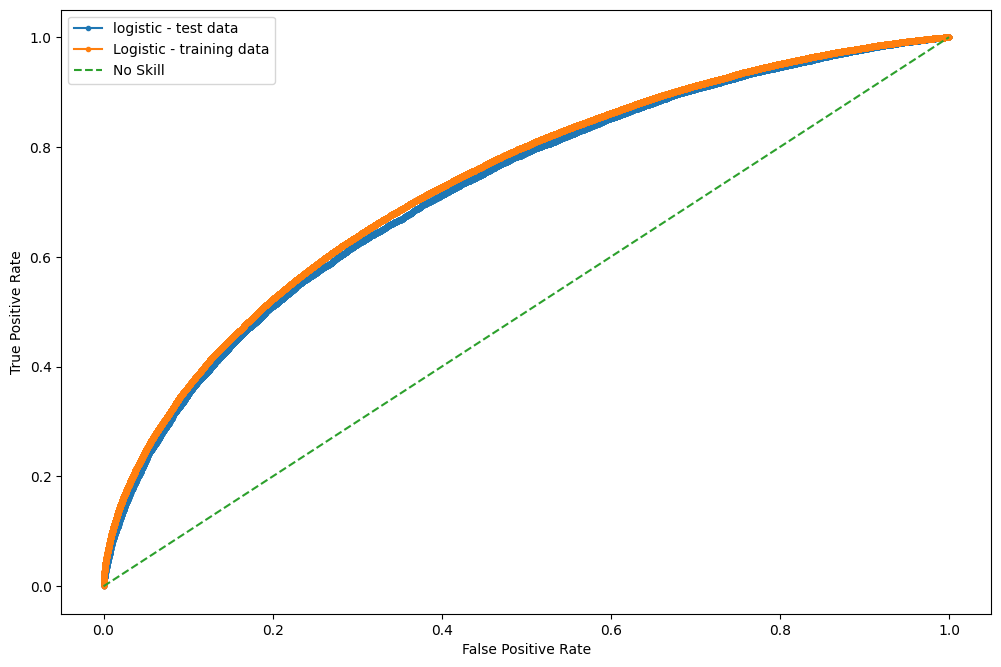

In [17]:
# plot roc curve
plt.plot(fpr_test, tpr_test, marker='.', label='logistic - test data') 
plt.plot(fpr, tpr, marker='.', label='Logistic - training data') 
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()


In [18]:
# display the auc scores and calculate the delta between the AUC for the training vs. test data

# calculate and print AUROC
roc_auc = metrics.roc_auc_score(y_test, yhat_positive)

# calculate and print AUROC
roc_auc_train = metrics.roc_auc_score(y_train, yhat_positive_train)

# calculate the difference in ROC curves 
roc_diff = abs(roc_auc_train - roc_auc)

roc_dict = {'ROC Test Data': roc_auc,
            'ROC Training Data': roc_auc_train,
            'Diff in ROC Curves': roc_diff}

roc_df = pd.DataFrame(roc_dict, index=[0])

roc_df = roc_df.round(3)

roc_df.head()

,ROC Test Data,ROC Training Data,Diff in ROC Curves
0,0.722,0.732,0.011


The model "has skill" given that the the AUC scores are above the 0.5 line we could achieve via just guessing, and the small difference in the curves for testing and training data suggests that we don't have any overfitting issues. 

In [19]:
# let's grab the predictions so we can determine the economic performance of the loans selected by the model 

columns = ['predictions']

predictions_df = pd.DataFrame(predictions, columns=columns)
predictions_df.head()

,predictions
0,1
1,1
2,1
3,0
4,1


In [20]:
# make a copy of the data frame created earlier for $ performance analysis 
# we do this so that we always have a fresh copy as we evaluate different models 

model_one = test_portfolio.copy()

# add the predictions to the data frame

model_one = model_one.join(predictions_df)

model_one.head()

,funded_amnt,int_rate,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,pub_rec_bankruptcies,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,pct_tl_nvr_dlq,tot_coll_amt,total_bal_ex_mort,emp_length_months,dti_dec,total_payments,net_gain,debt_consolidation,consumer_credit,other,countdown_zero_delinq,countdown_zero_revol_delinq,term_ 36 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,paid,application_type_Individual,predictions
0,28000.0,0.0789,2.0,695.0,0.0,6.0,21.0,0.0,0.0,0.518,40.0,0.0,0.0,0.0,8.0,18869.0,0.0,250.0,8.0,8.0,4.0,1.0,17.0,0.0,11.0,0.0,95.0,0.0,103190.0,120,0.1742,35.973398,3512.70,1,0,0,-78.0,-67.0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1
1,35000.0,0.0692,0.0,700.0,0.0,64.0,5.0,0.0,0.0,0.000,26.0,0.0,0.0,0.0,0.0,14244.0,0.0,258.0,30.0,28.0,3.0,10.0,0.0,1.0,1.0,0.0,95.7,0.0,71221.0,12,0.0882,36.003003,3862.36,1,0,0,-20.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2,15000.0,0.1229,1.0,690.0,2.0,19.0,42.0,0.0,0.0,0.189,58.0,0.0,0.0,0.0,17.0,5884.0,0.0,170.0,3.0,3.0,4.0,5.0,19.0,0.0,3.0,0.0,94.8,0.0,23108.0,24,0.1347,31.553908,786.42,1,0,0,-65.0,-65.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1
3,9450.0,0.2399,0.0,670.0,0.0,27.0,6.0,0.0,0.0,0.215,13.0,0.0,0.0,0.0,7.0,1195.0,0.0,99.0,3.0,3.0,0.0,19.0,27.0,2.0,5.0,0.0,83.3,0.0,7172.0,36,0.1452,16.724771,-3914.54,0,1,0,-57.0,-57.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,5000.0,0.1199,1.0,725.0,1.0,14.0,13.0,0.0,0.0,0.229,22.0,0.0,0.0,0.0,11.0,8031.0,0.0,188.0,2.0,2.0,1.0,6.0,0.0,0.0,7.0,0.0,95.5,0.0,34629.0,120,0.2766,35.875650,957.15,1,0,0,-70.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1


In [21]:
# isolate just the loans identified by the model as "good"

model_one_selected = model_one[(model_one['predictions'] >0)]



In [22]:
# performance of test portfolio for reference 

portfolio_performance = eda_functions.calc_performance(test_portfolio)
portfolio_performance.head()

,total_loan_value,total_net_gains,avg_interest rate,avg_loan_amount,avg_gains($),avg_gains(%),annualized_return
0,1180149275.0,69884704.400058,12.54789,15283.740093,905.054709,5.921683,1.920887


In [23]:
# performance of the first model 

model_one_performance = eda_functions.calc_performance(model_one_selected)
model_one_performance


,total_loan_value,total_net_gains,avg_interest rate,avg_loan_amount,avg_gains($),avg_gains(%),annualized_return
0,675648800.0,53682768.990018,10.044185,14140.236909,1123.493554,7.945366,2.605083


In [24]:
# let's extrapolate the total loan value and total net gains to the size of the entire dataset 

model_one_extrapolated = model_one_performance.copy()


model_one_extrapolated['total_loan_value'] = (5 * model_one_extrapolated['total_loan_value'])
model_one_extrapolated['total_net_gains'] = (5 * model_one_extrapolated['total_net_gains'])

model_one_extrapolated

,total_loan_value,total_net_gains,avg_interest rate,avg_loan_amount,avg_gains($),avg_gains(%),annualized_return
0,3378244000.0,268413844.950092,10.044185,14140.236909,1123.493554,7.945366,2.605083


#### Key Take Aways
* Compared to the performance of the loans in the testing dataset, this model would increase annualized returns by 38.5% (% change from 1.92% to 2.65%). 
* If we were to extrapolate to the results on the test dataset to the overall loan portfolio, we could estimate the following:
    * 11.2% default rate
    * 275M in returns vs. 3.4B in capital 
    * The model would deliver roughly 80M fewer in returns, but require nearly 2.5B less capital to do so 
* This model would outperform the proposed intervention of setting an interest cap of 13.5%, because it would deliver about 7M more in revenue, while also using about 17M less capital. 
* The company would generate smaller returns in absolute terms if they used this model, 22% less in absolute terms, but their % returns would increase because they would generate those returns via deploying 45% less capital. Another way to look at is that the capital cost to generate returns from their loan portfolio would be nearly cut in half. 
* This model has the highest annualized returns compared to the two interventions proposed in the EDA Notebook:
    * No loans below Grade D, 2.2% annualized return
    * Setting a interest rate cap of 13.5%, 2.4% annualized return
* The value this model would have for the company would depend on a lot of factors: namely, are they trying to optimize for capital efficiency or gross returns? Also, the company could elect to make up the difference with growth and marketing. I.e. aggressively seek out additional customers who meet their new lending standards.
* The model and the suggested interventions from the data analysis are saying the same thing, after a certain point capital efficiency drops off substantially and the company is investing a large sum of money for very little gain. 


In [25]:
# of loans selected by the model as "good"

model_one_count = len(model_one_selected)
model_one_count

47782

In [26]:
# default rate 

default_rate_model_one = 1 - model_one_selected['paid'].mean()
default_rate_model_one

0.11265748608262527

In [27]:
%%time

# before we attempt to improve the model further, let's conduct stratified cross validation where we 
# split the entire dataset into chunks (folds) and go through several training and test cycles. We do this to 
# as it its a better measure of how the model would perform on new data 


# define evaluation procedure - using Stratified Kfold + the Shuffle parameter ensures that each "fold"
# has the same ratio of good to bad loans as the dataset overall. 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# evaluate model
#results = cross_val_score(model, X_scale, y, scoring='f1', cv=cv)
results = cross_val_score(model, X_scale, y, scoring='f1', cv=cv)

print("F1 Score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))





F1 Score: 75.12% (0.15%)
CPU times: user 1min 10s, sys: 618 ms, total: 1min 11s
Wall time: 1min 11s


In [28]:
print(results)

[0.75254111 0.7497208  0.75138122 0.75213707 0.7508832  0.74820707
 0.75367265 0.75228162 0.75125581 0.75033517]


The F1 score from cross fold validation being slightly smaller than what we see from typical model fitting, suggests that the model would perform only slightly worse on new data than it does on the training data. It's worth noting that an earlier attempt used 33% of the data for testing and delivered an F1 score of 82, while the F1 from cross validation was nearly exactly the same as is shown above. I.e. this step allowed us to do a better job of setting the testing vs. training cut off, with the outcome being a higher performing model. 

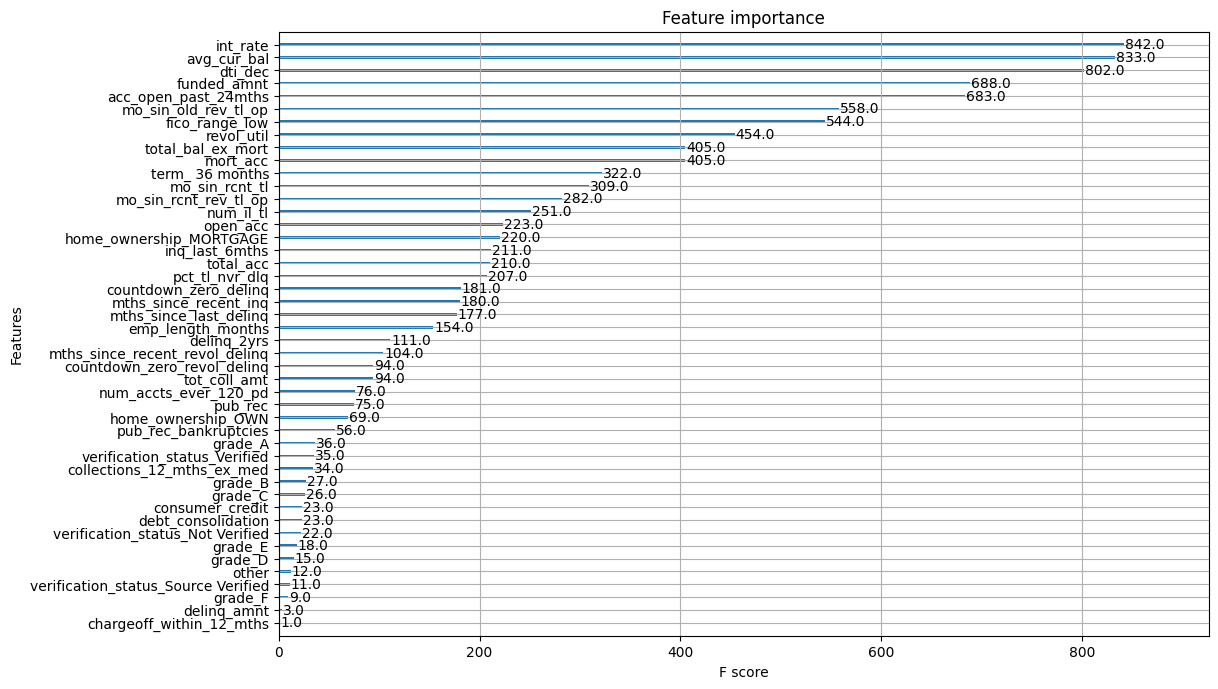

In [29]:
# show the feature importances 

plot_importance(model)
pyplot.show()


Looking at the feature importances, the general pattern is that affordability and debt load are what are driving defaults, in terms of debt to income ratio, credit card balances, size of payments and other factors related to how well they're managing their debt. Overall, these numbers aren't particularly surprising: the defaults are trending in line with the customers that traditional credit measures deem as higher risk. 


In [30]:
%%time 


model_two = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02,objective='reg:logistic',  max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.237, eval_metric='auc', subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

model_two.fit(X_train, y_train)
predictions = model_two.predict(X_test)
f1_score = f1_score(y_test, predictions)
print(f1_score)

0.7716700944994609
CPU times: user 6.82 s, sys: 39.7 ms, total: 6.86 s
Wall time: 6.88 s


In [31]:
%%time

from sklearn.metrics import f1_score

# we'll use the data above to re-run the model but go through various thresholds 
# to see if we improve performance by getting rid of various features. 

thresholds = sort(model_two.feature_importances_)

for i in thresholds:
    selection = SelectFromModel(model_two, threshold = i, prefit = True)
    select_X_train = selection.transform(X_train)
    
    selection_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02,objective='reg:logistic',  max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.237, eval_metric='auc', subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
    
    selection_model.fit(select_X_train, y_train)
    
    
    # model evaluation 
    select_X_test = selection.transform(X_test)
    threshold_predictions = selection_model.predict(select_X_test)
    f1 = f1_score(y_test, threshold_predictions)
    print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (i, select_X_train.shape[1], 100*f1))
    



Thresh=0.000, n=51, F1 Score: 77.17%
Thresh=0.000, n=51, F1 Score: 77.17%
Thresh=0.000, n=51, F1 Score: 77.17%
Thresh=0.002, n=48, F1 Score: 76.93%
Thresh=0.003, n=47, F1 Score: 77.17%
Thresh=0.003, n=46, F1 Score: 77.26%
Thresh=0.003, n=45, F1 Score: 76.88%
Thresh=0.003, n=44, F1 Score: 77.05%
Thresh=0.003, n=43, F1 Score: 77.30%
Thresh=0.004, n=42, F1 Score: 77.17%
Thresh=0.004, n=41, F1 Score: 77.36%
Thresh=0.004, n=40, F1 Score: 77.02%
Thresh=0.004, n=39, F1 Score: 77.03%
Thresh=0.004, n=38, F1 Score: 76.62%
Thresh=0.004, n=37, F1 Score: 76.22%
Thresh=0.004, n=36, F1 Score: 76.92%
Thresh=0.004, n=35, F1 Score: 76.49%
Thresh=0.004, n=34, F1 Score: 76.82%
Thresh=0.004, n=33, F1 Score: 76.11%
Thresh=0.004, n=32, F1 Score: 76.61%
Thresh=0.004, n=31, F1 Score: 76.12%
Thresh=0.004, n=30, F1 Score: 75.71%
Thresh=0.004, n=29, F1 Score: 76.24%
Thresh=0.004, n=28, F1 Score: 76.53%
Thresh=0.004, n=27, F1 Score: 77.66%
Thresh=0.004, n=26, F1 Score: 77.57%
Thresh=0.004, n=25, F1 Score: 77.31%
T

It appears that once you get past 13 features, the additional features don't appear to add much value to the model, because while there are some fluctuations, the F1-score stays around 77. Given the feature importances, it appears that interventions that would reduce defaults would be fairly simple: make the loans more affordable to mitigate the problems the customers are having with keeping up with their expenses. 

Consider the following:

* A group of 1,000 customers in danger of default, who represent a potential loss of 7.5M based on the average loss of 7.5k per bad loan 
* Let's say all 1,000 customers are offered interventions of ~1.5k/each, as far as reduced payments, interest rates,etc and half take the offers and use the entire incentive and of those 500 customers, only 100 avoid default. 
    * Total intervention cost: 750k
    * Avoided losses from the 100 who pay off their loans: 750k
    * Given that you would only need to reduced defaults by 10% for interventions to be revenue neutral, plus the potential gains from the other customers who take advantage potentially making more payments, there is strong potential for significant avoided losses. 
    * A good approach could be just structuring interventions so that you only need a 10% success rate to come out ahead, and/or structuring them so that customers have to take make several payments to receive the entire benefit. 



In [32]:
%%time

# for reference, we'll run the model via logistic regression 
# commented out the code since we won't use it, have included a screenshot of the results
# as you can see the XG Boost are slightly better, but can be generated in about 7 seconds (with GPU)
# vs. 11 1/2 minutes for the model below. 

#from sklearn.linear_model import LogisticRegression

# l1 "Lasso Regression" logistic model, which uses an 'l1 penalty' 
# the penalty effectively scales with model complexity to force the model to generalize and avoid overfitting 
# l1 penalty is called the "absolute value of magnitude"
# An overview of the penalties can be found here: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c 
# The balanced hyperparameter is used to handle the fact that the dataset is unbalanced 

# create the model 
#lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=123)

# fit the model 
#lr.fit(X_train, y_train)

# generate predictions and a confusion matrix 
#y_pred = lr.predict(X_test)
#cm = confusion_matrix(y_test, y_pred)

# display the confusion matrix and print the classification report 

#print(cm)
#print(classification_report(y_test, y_pred))

# print default rate 

#fp = cm[0, 1]
#tp = cm[1, 1]

#default_rate = fp / (fp + tp)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


XG Boost only delivers slightly better results, however, since XG Boost can be accelerated via GPU the results are delivered in seconds vs over 15 minutes for an Sklearn L1 Logistical Model. Note: this model delivered better results than decision trees, or an L2 regressor. 

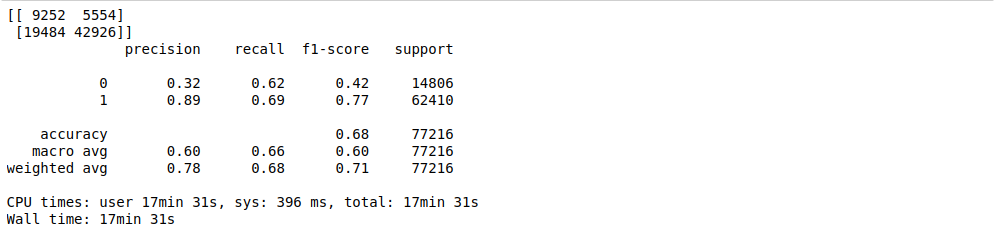

In [33]:
%%time 

# commented this out as it takes a rather long time, 
#screenshot below shows the results from one of the times the model was run

#cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# evaluate model
#lr_results = cross_val_score(lr, X_scale, y, scoring='f1', cv=cv)

#print("F1 Score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


Similarly to the L1 regressor vs. XG Boost, running cross validation with Sklearn took several hours due to the unavailability of GPU acceleration, while the same training and validation method took a little over a minute with GPU acceleration using XG Boost. I.e. beyond the slightly better results, XG Boost is just a vastly superior option as it enables a data scientist to rapidly try different approaches, data and hyperparameters without needing to wait hours to get the results. 


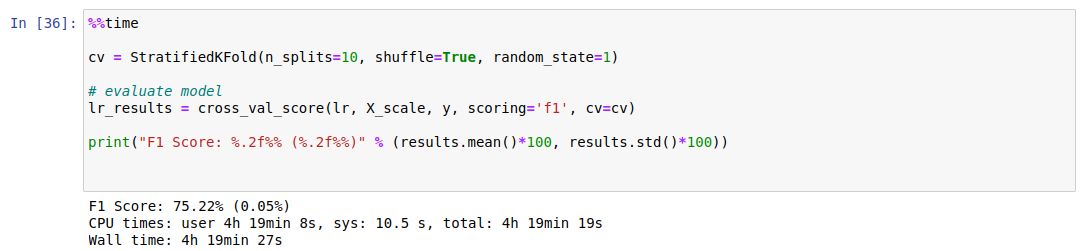


#### Final Take Aways 
* The model delivers significant value in terms of increasing capital efficiency, how a company would use would depend on how they want to optimize their business moving forward. 
* Only the top 13 features provide value in terms of predicting defaults, which appear to largely be a function of interest rate, post loan debt to income ratio, credit card balances/usage and the payment amount
* Potential interventions to reduce defaults should be focused on reducing payment amounts and interest rates; even a small reduction in defaults could easily cover the cost of the interventions.
* The model needs more data, both in terms of volume and in terms of data that actually predicts loan defaults, as the dataset contained nearly 40 features that added nothing to the model's accuracy. 